In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Load Data

### For Collab

In [61]:
# train_dir = './data/train'
# test_dir = './data/test'
# validation_dir = './data/val'

### For Kaggle

In [62]:
train_dir = '/kaggle/input/depression-dataset-on-facial-ecpression-images/Depression Data/data/train'
test_dir = '/kaggle/input/depression-dataset-on-facial-ecpression-images/Depression Data/data/test'
validation_dir = '/kaggle/input/depression-dataset-on-facial-ecpression-images/Depression Data/data/val'

In [63]:
# Define image dimensions and batch size
img_width, img_height = 256, 256
batch_size = 32

In [64]:
# Create data generators with data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [65]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [66]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
)

Found 3155 images belonging to 7 classes.


In [67]:
validation_generator = val_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
)

Found 328 images belonging to 7 classes.


In [68]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
)

Found 328 images belonging to 7 classes.


# Model

In [69]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # Output layer with 7 units

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [70]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001  # Initial learning rate
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * 0.1  # Reduce learning rate after 10 epochs

In [71]:
# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

In [72]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,           # Stop after 10 epochs without improvement
    restore_best_weights=True
)

In [73]:
# Train the model
num_epochs = 15
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train the model on the training data
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        epochs=1,  # Train for 1 epoch at a time
        verbose=1,
        callbacks=[early_stopping]
    )
    # Collect and store training and validation losses for this epoch
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])

    # Collect and store training and validation accuracies for this epoch
    train_accuracies.append(history.history['accuracy'][0])
    val_accuracies.append(history.history['val_accuracy'][0])

    # Calculate validation accuracy
    val_loss, val_accuracy = model.evaluate(validation_generator, verbose=0)
    print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

Epoch 1/15
99/99 [==============================] - 50s 487ms/step - loss: 1.9756 - accuracy: 0.1930 - val_loss: 1.8847 - val_accuracy: 0.1616
Validation Accuracy: 16.16%
Epoch 2/15
99/99 [==============================] - 49s 491ms/step - loss: 1.8111 - accuracy: 0.2139 - val_loss: 1.9209 - val_accuracy: 0.2165
Validation Accuracy: 21.65%
Epoch 3/15
99/99 [==============================] - 48s 487ms/step - loss: 1.7785 - accuracy: 0.2203 - val_loss: 1.9250 - val_accuracy: 0.2165
Validation Accuracy: 21.65%
Epoch 4/15
99/99 [==============================] - 48s 480ms/step - loss: 1.7694 - accuracy: 0.2311 - val_loss: 1.8675 - val_accuracy: 0.2195
Validation Accuracy: 21.95%
Epoch 5/15
99/99 [==============================] - 47s 475ms/step - loss: 1.7694 - accuracy: 0.2269 - val_loss: 1.8687 - val_accuracy: 0.2348
Validation Accuracy: 23.48%
Epoch 6/15
99/99 [==============================] - 47s 477ms/step - loss: 1.7689 - accuracy: 0.2200 - val_loss: 1.8483 - val_accuracy: 0.2195
Va

# Evaluation

In [74]:
from matplotlib import pyplot as plt

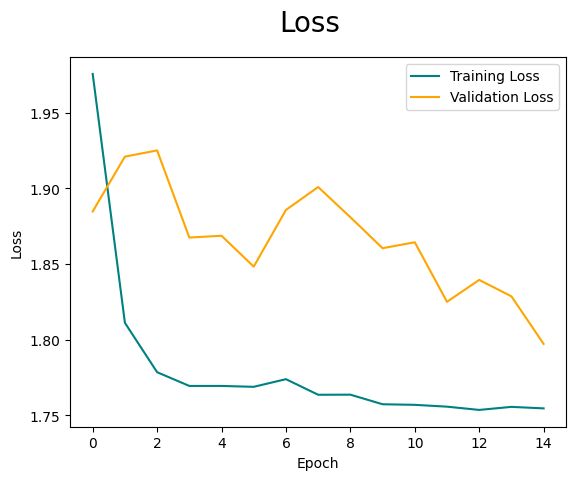

In [75]:
fig = plt.figure()
plt.plot(train_losses, color='teal', label='Training Loss')
plt.plot(val_losses, color='orange', label='Validation Loss')
fig.suptitle('Loss', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.show()

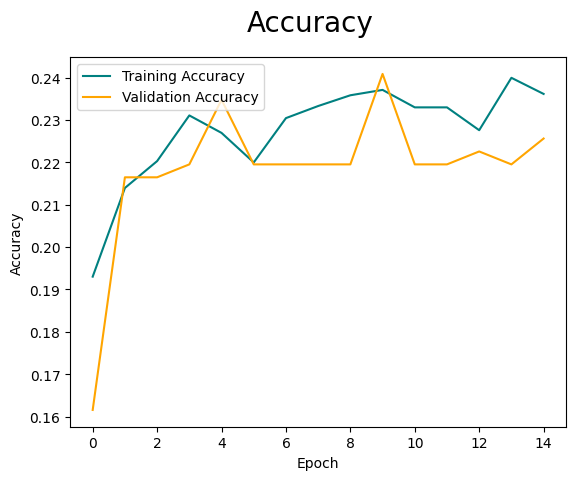

In [76]:
fig = plt.figure()
plt.plot(train_accuracies, color='teal', label='Training Accuracy')
plt.plot(val_accuracies, color='orange', label='Validation Accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

# Test

In [77]:
import cv2

In [137]:
image_path = test_dir + '/Happy/105.png'

In [138]:
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

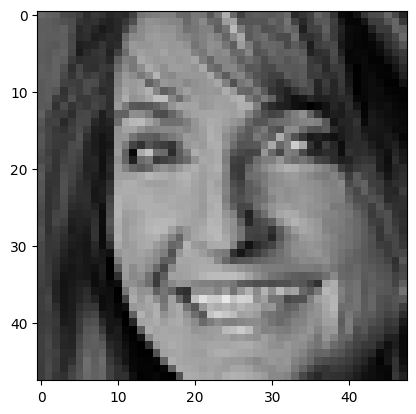

In [139]:
plt.imshow(img)
plt.show()

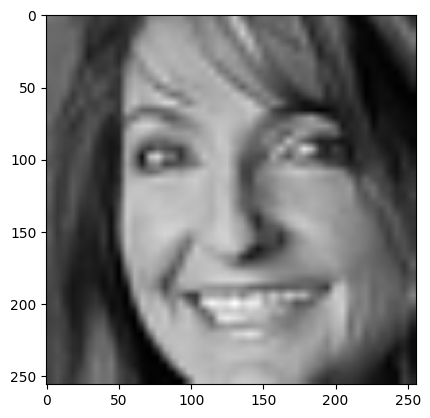

In [140]:
resize = tf.image.resize(img, (256, 256))
grayscale = tf.image.rgb_to_grayscale(resize)
plt.imshow(grayscale.numpy().squeeze(), cmap='gray')
plt.show()

In [141]:
import numpy as np

In [142]:
yhat = model.predict(np.expand_dims(resize/255,0))
print(yhat)

1/1 [==============================] - 0s 19ms/step
[[6.1227396e-02 1.3797013e-01 6.7385495e-02 5.3541285e-01 6.8566404e-02
  1.2943751e-01 2.1580603e-07]]


In [143]:
# Define the class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Use argmax to find the index of the highest probability
predicted_class_index = np.argmax( np.array(yhat))

# Get the corresponding class label
predicted_class = class_labels[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

Predicted Class: Happy


In [85]:
# if np.any(yhat > 0.2):
#     print(f'Predicted class is Happy')
# else:
#     print(f'Predicted class is something else')

In [86]:
# # Read the image using cv2.imread
# img = cv2.imread(image_path)

# # Resize the image to match the input size used during training
# resize = tf.image.resize(img, (256, 256))

# # Make predictions for the resized image
# predictions = model.predict(np.expand_dims(resize/255, 0))

# # Interpret the predictions for binary classification
# predicted_class_label = "Happy" if predictions[0][0] < 0.5 else "something"

# # Display the predicted class label
# print(f'Predicted class is {predicted_class_label}')